
# Visualizing and Understanding the Thomas Fire

By: Takeen Shamloo

Date: Dec 4th, 2024

Class: EDS 220

[Thomas Fire GitHub Repo](https://github.com/takeenshamloo/thomas-fire-analysis)

## About the Analysis

The Thomas Fire, one of California's largest wildfires significantly impacted air quality in Santa Barbara County during December 2017. We are going to dive into two different ways of looking at the fire’s effects:

- **Air Quality Analysis**: We’ll look at AQI trends during 2017-2018 to see how the fire impacted air quality.
- **False Color Imagery**: We’ll use satellite data to get a closer look at how the fire changed the landscape, like burn scars and vegetation health.

False Color Imagery is like using a filter on satellite photos to highlight things you can’t see with just your eyes. This way we can spot areas that were burned or stressed during and after the fire. Combining this with AQI analysis gives us a better idea of how the fire impacted both the air and the land.

![Thomas Fire](https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1000w,f_auto,q_auto:best/newscms/2019_11/2785271/190313-thomas-fire-2017-ac-721p.jpg)
*Source: NBC News*


### **Data Citations**
The following code uses data from the sources below:

1. **Air Quality Index (AQI) Dataset**  
   This dataset contains daily AQI measurements for counties across the United States, used to analyze how the Thomas Fire affected air quality in Santa Barbara County.  
   U.S. Environmental Protection Agency. (n.d.). *Air Quality Index (AQI) Data* [Data set]. Retrieved December 4, 2024, from [https://aqs.epa.gov/aqsweb/airdata/download_files.html#Daily](https://aqs.epa.gov/aqsweb/airdata/download_files.html#Daily)

2. **Landsat Bands Dataset**  
   This dataset includes a simplified collection of bands (Red, Green, Blue, Near-Infrared, and Shortwave Infrared) from Landsat 8, used to create True Color and False Color images for the Thomas Fire area.  
   Microsoft. (n.d.). *Landsat Collection 2 Level-2 (C2 L2) Data* [Data set]. Microsoft Planetary Computer. Retrieved December 4, 2024, from [https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)

3. **Fire Perimeter Dataset**  
   This dataset provides geospatial boundaries for fire perimeters in California. For this analysis, the data was filtered to focus on the 2017 Thomas Fire.  
   U.S. Government. (n.d.). *California Fire Perimeters (ALL)* [Data set]. Data.gov. Retrieved December 4, 2024, from [https://catalog.data.gov/dataset/california-fire-perimeters-all](https://catalog.data.gov/dataset/california-fire-perimeters-all)



## Organized Analysis

The workflow begins as follows:


### Loading Necessary Packages

In [37]:
# Importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Additional Libraries for Part 2 
import rioxarray as rioxr
import os
import geopandas as gpd
from rasterio.plot import show
import fiona
from shapely.geometry import shape

# Remove warnings
warnings.filterwarnings('ignore')


We’re using three Python libraries to make all this happen:
- `pandas`: For loading, cleaning, and organizing our data.
- `numpy`: Used here for some extra math functions.
- `matplotlib.pyplot`: The go-to library for creating plots. This is how we’ll bring the AQI trends to life with visuals.

Additional Libraries (For Part 2):
- `rioxarray`: This one’s a powerhouse for working with geospatial raster data, like satellite images. We use it for loading and visualizing Landsat data which is typically stored in raster formats like NetCDF.
- `os`: Helps us handle file paths and manage data directories.
- `geopandas`: Used to process and visualize the geospatial fire perimeter data.
- `fiona`: Handles shapefile formats to load the Thomas Fire boundary data which we overlay on our maps. We used since we had a version conflict with geopandas built in version of this same package. 
- `shapely`: Analyzes geometric objects, like polygons, to map the fire perimeter.

## Part 1: Air Quality Analysis During the Thomas Fire

**Description**:  

For this section we will be analyzing air quality info (AQI) during the Thomas Fire. By looking at daily AQI and calculating a 5-day rolling average we can see how the fire impacted air quality in Santa Barbara County.

The AQI dataset includes daily air quality measurements for every county in the U.S. These values are essential for spotting anomalies and understanding how wildfire events affect local air quality.

### Data Loading

In [38]:
# Loading the data
#aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip", compression='zip')
#aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip", compression='zip')

# Server was down had to used downloaded csv files of the data
aqi_17 = pd.read_csv("data/daily_aqi_by_county_2017.csv")
aqi_18 = pd.read_csv("data/daily_aqi_by_county_2018.csv")

So, first off, we couldn’t grab the data from the internet directly because the server was down but I have left the commented out code if needed. Instead, downloaded the data locally as CSV files. They have all the air quality info (AQI) for every county in the U.S. for 2017 and 2018. Each file is a year’s worth of daily AQI data.

### Combining Datasets and Cleaning Column Names

In [39]:
# Combining datasets and cleaning column names
aqi = pd.concat([aqi_17, aqi_18])
aqi.columns = aqi.columns.str.lower().str.replace(' ', '_')

Here we’re smushing the 2017 and 2018 data into one big dataset so we can look at everything together. I cleaned up the column names too and made them lowercase as well as swapped out spaces for underscores. This step is imperative as it will make the data a lot easier to work with later.

### Filtering for Santa Barbara County

In [40]:
# Filtering for Santa Barbara County
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']
aqi_sb = aqi_sb.drop(['state_name', 'county_name', 'state_code', 'county_code'], axis=1)

This step is fairly simple we only care about Santa Barbara County, so I filtered out the rest of the data. Also, I ditched some columns like state name and county code since we don’t really need those. No point keeping extra stuff around that could potentially confuse us later.

### Converting Data and Setting the Index

In [41]:
# Converting date column to datetime and setting it as the index
aqi_sb['date'] = pd.to_datetime(aqi_sb['date'])
aqi_sb = aqi_sb.set_index('date')

Using the code above I made sure the date column is in a proper date format because we’re working with time-series data (fancy word for data over time). Then I set it as the index which just means we can use the dates to organize the data.

### Calculating the 5-Day Rolling Average

In [42]:
# Calculating a 5-day rolling average for AQI
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean()


This is where the fun begins! I calculated a 5-day rolling average. Basically, it smooths out the daily ups and downs so we can see bigger trends. It’s like looking at the bigger picture instead of freaking out about every little bump.

### Visualizing the Results

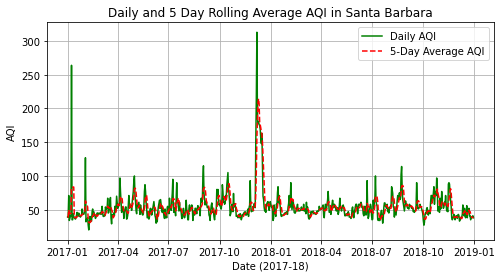

In [43]:
# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(aqi_sb.index.values, aqi_sb['aqi'].values, label='Daily AQI', color='green', linewidth=1.5)
plt.plot(aqi_sb.index.values, aqi_sb['five_day_average'].values, label='5-Day Average AQI', color='red', linestyle='--', linewidth=1.5)
plt.title('Daily and 5 Day Rolling Average AQI in Santa Barbara')
plt.xlabel('Date (2017-18)')
plt.ylabel('AQI')
plt.legend()
plt.grid()
plt.show()

Based on my visualization, the graph to show what’s happening with AQI. The green line is the daily AQI which jumps around a lot. The red dashed line is the 5-day rolling average which is way smoother. You can see a massive spike in December 2017 because of the Thomas Fire we can see AQI at a peak reading of ~265 AQI score which is way over the ~50 AQI score we can see assume off the baseline.


# Part 2: False Color Imagery of the Thomas Fire

**Description**: This section highlights the use of Landsat satellite data to create True Color and False Color images. These images reveal details about burn severity and vegetation health following the Thomas Fire.

The Landsat bands dataset includes Red, Green, Blue, Near-Infrared, and Shortwave Infrared bands. These are essential for creating True and False Color imagery.

### Data Loading

In [44]:
# Define path to Landsat data
landsat_path = 'data/landsat8-2018-01-26-sb-simplified.nc'

# Load dataset
landsat_data = rioxr.open_rasterio(landsat_path)
print(landsat_data)

<xarray.Dataset>
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...


#### Creating a True Color Image

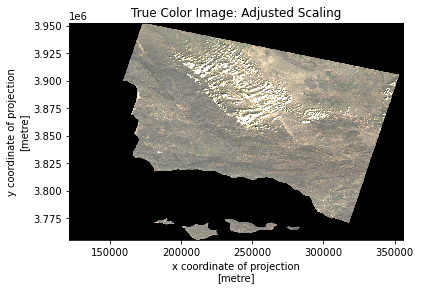

In [45]:
# Drop the band dimension
landsat_data = landsat_data.squeeze(dim = "band")

# Select bands and create True Color image (adjusting for cloud coverage)
landsat_data[['red', 'green', 'blue']].to_array().plot.imshow(robust = True)
plt.title("True Color Image: Adjusted Scaling")
plt.show()

A True Color image is constructed using the Red, Green, and Blue bands. Shows us what we would expect from a satellite image. Shows the detail in terrain and cloud coverage at the time.

#### Creating a False Color Image

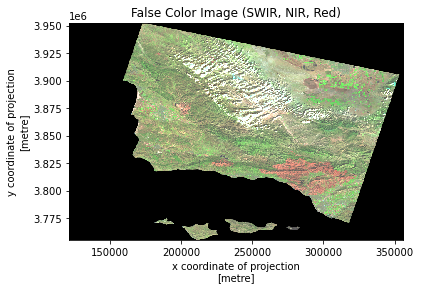

In [46]:
# Select bands for False Color image (Short Wave Infrared, Near-Infrared, and Red Bands)
landsat_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)
plt.title("False Color Image (SWIR, NIR, Red)")
plt.show()

False Color imagery combines Shortwave Infrared, Near-Infrared, and Red bands to highlight fire scars which we can see given the different shades of red on our map.

#### Loading and Handling Shape Files for the Thomas Fire's Perimeter 

In [47]:
# Load the fire perimeter shapefile using Fiona
shapefile_path = "data/fire_perimeter/California_Fire_Perimeters_(all).shp"
with fiona.open(shapefile_path, "r") as shapefile:
    records = [feature for feature in shapefile]
    shapefile_crs = shapefile.crs  # Extract CRS from Fiona

# Convert Fiona records to a GeoDataFrame
geometries = [shape(record["geometry"]) for record in records]
attributes = [record["properties"] for record in records]
fire_perimeter = gpd.GeoDataFrame(attributes, geometry = geometries, crs = shapefile_crs)

# Filter for the 2017 Thomas Fire
thomas_fire = fire_perimeter[
    (fire_perimeter["YEAR_"] == 2017) &
    (fire_perimeter["FIRE_NAME"].str.contains("Thomas", case = False))
]

# Explicitly set CRS for thomas_fire from fire_perimeter
thomas_fire.set_crs(fire_perimeter.crs, inplace = True)

# Align CRS of Thomas Fire to Landsat data
thomas_fire = thomas_fire.to_crs(landsat_data.rio.crs)

From the previous plots we could notice a lot of small patches which could be indicative of the many fires that we have recorded in our data, but our interest lies with the Thomas Fire. Here we set up the perimeter of the Thomas Fire which we will overlay it on the map later.

#### Mapping the Fire Perimeter

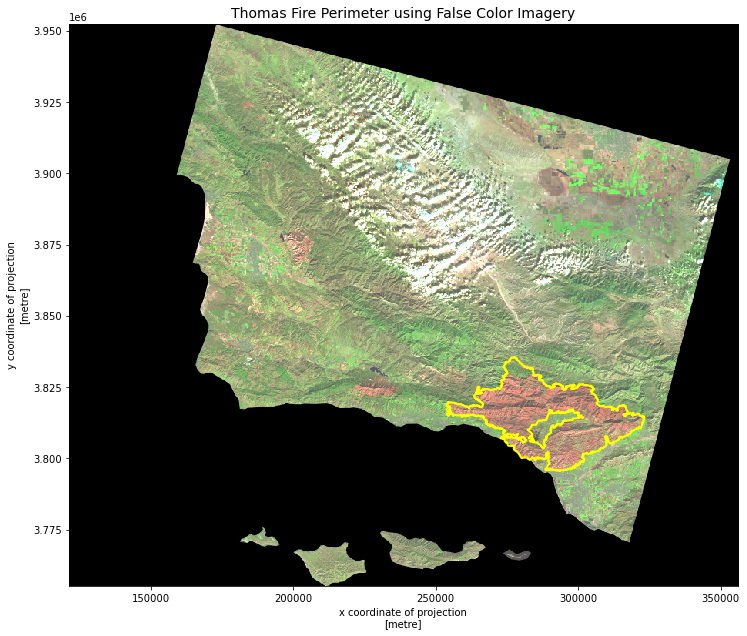

In [48]:
# Overlay False Color Image with Thomas Fire Perimeter
fig, ax = plt.subplots(figsize = (12, 12))
landsat_data[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True, ax = ax)
thomas_fire.plot(ax = ax, edgecolor = "yellow", facecolor="none", linewidth = 2, label = "Thomas Fire Perimeter")

# Add title
plt.title("Thomas Fire Perimeter using False Color Imagery", fontsize = 14)
plt.show()

Finally, we overlay the Thomas Fire perimeter on the False Color image. This shows exactly where the fire burned. We can see distinctly see how large of an impact it had in comparison to the other scars on our plot.